<a href="https://colab.research.google.com/github/joejackson6/ComputerSecurityHW/blob/main/Project/Milestone2/Progress_Check_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial progress on the NBA Project

In [ ]:
# Mount to Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Get Data
path_to_games = "/content/drive/MyDrive/Neural Networks/Progress Check 2/games.csv"
path_to_game_details = "/content/drive/MyDrive/Neural Networks/Progress Check 2/games_details.csv"
path_to_players = "/content/drive/MyDrive/Neural Networks/Progress Check 2/players.csv"
path_to_ranking = "/content/drive/MyDrive/Neural Networks/Progress Check 2/ranking.csv"

# Get the data from the files
games = pd.read_csv(path_to_games)
game_details = pd.read_csv(path_to_game_details)
players = pd.read_csv(path_to_players)
ranking = pd.read_csv(path_to_ranking)

<ipython-input-4-76cb0dddc7e9>:9: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  game_details = pd.read_csv(path_to_game_details)


For this part of the project I am going to try and simplify to predict games exclusively for the year 2018/2019 to explore different ideas and see what might work better.

In [ ]:
# Process data to only include games from 2018/2019 season
games_2018 = games[games['SEASON'] == 2018]
#print(games2018)
game_details_2018 = game_details[game_details['GAME_ID'].isin(games_2018['GAME_ID'])]
#print(game_details2018)
ranking_2018 = ranking[ranking['SEASON_ID'] == 22018]
#print(ranking_2018)

# Print the columns for all of the data (using to merge data)
#print("games columns", games.columns)
#print("game_details columns", game_details.columns)
#print("ranking columns", ranking.columns)

In [ ]:
games_2018 = games_2018.drop(columns=['GAME_STATUS_TEXT', 'SEASON'], errors='ignore')
ranking_2018 = ranking_2018.drop(columns=['LEAGUE_ID', 'SEASON_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'G', 'W', 'L', 'RETURNTOPLAY'], errors='ignore')

ranking_2018 = ranking_2018.sort_values(by=['TEAM_ID'], ascending=True).drop_duplicates(subset=['TEAM_ID'], keep='last')
ranking_dict = ranking_2018.set_index('TEAM_ID').to_dict(orient='index')

game_details_2018 = game_details_2018[['GAME_ID', 'TEAM_ID', 'PTS', 'AST', 'REB', 'STL', 'BLK', 'TO', 'FG_PCT', 'FG3_PCT', 'FT_PCT']]
game_details_agg_2018 = game_details_2018.groupby(['GAME_ID', 'TEAM_ID']).agg({
    'PTS': 'sum', 'AST': 'sum', 'REB': 'sum', 'STL': 'sum',
    'BLK': 'sum', 'TO': 'sum', 'FG_PCT': 'mean', 'FG3_PCT': 'mean', 'FT_PCT': 'mean'
}).to_dict(orient='index')

processed_data = []

for _, row in games_2018.iterrows():
    game_id = row['GAME_ID']
    home_team = row['TEAM_ID_home']
    away_team = row['TEAM_ID_away']

    home_ranking = ranking_dict.get(home_team, {})
    away_ranking = ranking_dict.get(away_team, {})

    home_stats = game_details_agg_2018.get((game_id, home_team), {})
    away_stats = game_details_agg_2018.get((game_id, away_team), {})

    combined_row = {
        **row.to_dict(),
        **{f"{k}_home": v for k, v in home_ranking.items()},
        **{f"{k}_away": v for k, v in away_ranking.items()},
        **{f"{k}_home": v for k, v in home_stats.items()},
        **{f"{k}_away": v for k, v in away_stats.items()}
    }

    processed_data.append(combined_row)

games_final = pd.DataFrame(processed_data)
print(games_final)



     GAME_DATE_EST   GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  TEAM_ID_home  \
0       2019-06-13  41800406    1610612744       1610612761    1610612744   
1       2019-06-10  41800405    1610612761       1610612744    1610612761   
2       2019-06-07  41800404    1610612744       1610612761    1610612744   
3       2019-06-05  41800403    1610612744       1610612761    1610612744   
4       2019-06-02  41800402    1610612761       1610612744    1610612761   
...            ...       ...           ...              ...           ...   
1373    2018-09-30  11800009    1610612741       1610612740    1610612741   
1374    2018-09-30  11800010    1610612747       1610612743    1610612747   
1375    2018-09-29  11800003    1610612761       1610612757    1610612761   
1376    2018-09-29  11800005    1610612744       1610612750    1610612744   
1377    2018-09-28  11800002    1610612766       1610612738    1610612766   

      PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  ...  \
0 

In [ ]:
# Create Teams dict
games_2018 = games[games['SEASON'] == 2018]
game_details_2018 = game_details[game_details['GAME_ID'].isin(games_2018['GAME_ID'])]
ranking_2018 = ranking[ranking['SEASON_ID'] == 22018]


games_2018 = games_2018.drop(columns=['GAME_STATUS_TEXT', 'SEASON'], errors='ignore')

ranking_2018 = ranking_2018.drop(columns=['LEAGUE_ID', 'SEASON_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'G', 'W', 'L', 'RETURNTOPLAY'], errors='ignore')

ranking_2018 = ranking_2018.sort_values(by=['TEAM_ID'], ascending=True).drop_duplicates(subset=['TEAM_ID'], keep='last')
ranking_dict = ranking_2018.set_index('TEAM_ID').to_dict(orient='index')

game_details_2018 = game_details_2018[['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'PLAYER_NAME', 'PTS', 'AST', 'REB', 'STL', 'BLK', 'TO', 'FG_PCT', 'FG3_PCT', 'FT_PCT']]

team_games_dict = {}

for _, row in game_details_2018.iterrows():
    game_id = row['GAME_ID']
    team_id = row['TEAM_ID']

    player_stats = {
        'GAME_ID': game_id,
        'PLAYER_ID': row['PLAYER_ID'],
        'PLAYER_NAME': row['PLAYER_NAME'],
        'PTS': row['PTS'],
        'AST': row['AST'],
        'REB': row['REB'],
        'STL': row['STL'],
        'BLK': row['BLK'],
        'TO': row['TO'],
        'FG_PCT': row['FG_PCT'],
        'FG3_PCT': row['FG3_PCT'],
        'FT_PCT': row['FT_PCT']
    }

    if team_id not in team_games_dict:
        team_games_dict[team_id] = []

    team_games_dict[team_id].append(player_stats)

# Checking to see if output is correct
#for team in team_games_dict:
 ##  for player_stats in team_games_dict[team]:
   #     print(player_stats)


In [ ]:
# Data normalization and pre-processing (Make sure to handle NaNs)
N_GAMES = 10 # Hyperparameter that could be explored
stats_columns = ['PTS', 'AST', 'REB', 'STL', 'BLK', 'TO', 'FG_PCT', 'FG3_PCT', 'FT_PCT']
feature_rows = []

for _, game in games_2018.iterrows():
    game_id = game['GAME_ID']
    home_team = game['TEAM_ID_home']
    away_team = game['TEAM_ID_away']

    home_games = [g for g in team_games_dict.get(home_team, []) if g['GAME_ID'] < game_id][-N_GAMES:]
    away_games = [g for g in team_games_dict.get(away_team, []) if g['GAME_ID'] < game_id][-N_GAMES:]

    def rolling_avg(games, stat):
        values = [g[stat] for g in games if not pd.isna(g[stat])]
        return np.mean(values) if values else 0

    home_features = {f"{stat}_home_avg": rolling_avg(home_games, stat) for stat in stats_columns}
    away_features = {f"{stat}_away_avg": rolling_avg(away_games, stat) for stat in stats_columns}

    home_win_pct = np.mean([1 if g['PTS'] > g['PTS'] else 0 for g in home_games]) if home_games else 0.5 # Neutral assumption
    away_win_pct = np.mean([1 if g['PTS'] > g['PTS'] else 0 for g in away_games]) if away_games else 0.5

    row = {
        "GAME_ID": game_id,
        "HOME_TEAM_ID": home_team,
        "AWAY_TEAM_ID": away_team,
        "HOME_WIN": game["HOME_TEAM_WINS"],
        "HOME_WIN_PCT": home_win_pct,
        "AWAY_WIN_PCT": away_win_pct,
        **home_features,
        **away_features,
    }

    feature_rows.append(row)

features_df = pd.DataFrame(feature_rows)

# Final NaN cleanup
features_df.fillna(0, inplace=True)
print(features_df)

# Save for later
features_df.to_csv("nba_model_features.csv", index=False)


       GAME_ID  HOME_TEAM_ID  AWAY_TEAM_ID  HOME_WIN  HOME_WIN_PCT  \
0     41800406    1610612744    1610612761         0           0.0   
1     41800405    1610612761    1610612744         0           0.0   
2     41800404    1610612744    1610612761         0           0.0   
3     41800403    1610612744    1610612761         0           0.0   
4     41800402    1610612761    1610612744         0           0.0   
...        ...           ...           ...       ...           ...   
1373  11800009    1610612741    1610612740         1           0.5   
1374  11800010    1610612747    1610612743         0           0.5   
1375  11800003    1610612761    1610612757         1           0.5   
1376  11800005    1610612744    1610612750         0           0.5   
1377  11800002    1610612766    1610612738         1           0.5   

      AWAY_WIN_PCT  PTS_home_avg  AST_home_avg  REB_home_avg  STL_home_avg  \
0              0.0           3.7         1.200          2.70         0.500   
1  

In [ ]:
# Process Data and split it into sections

df = pd.read_csv("nba_model_features.csv")

# Define static and sequential feature columns
static_features = ['HOME_WIN_PCT', 'AWAY_WIN_PCT']
seq_features = ['PTS', 'AST', 'REB', 'STL', 'BLK', 'TO', 'FG_PCT', 'FG3_PCT', 'FT_PCT']
N_GAMES = 10

# Normalize static features
scaler = StandardScaler()
df[static_features] = scaler.fit_transform(df[static_features])

# Prepare sequences
team_games = {}
sequences = []
targets = []

for _, row in df.iterrows():
    game_id = row['GAME_ID']
    home_team = row['HOME_TEAM_ID']
    away_team = row['AWAY_TEAM_ID']
    home_win = row['HOME_WIN']

    home_games = team_games.get(home_team, [])[-N_GAMES:]
    away_games = team_games.get(away_team, [])[-N_GAMES:]

    while len(home_games) < N_GAMES:
        home_games.insert(0, np.zeros(len(seq_features)))

    while len(away_games) < N_GAMES:
        away_games.insert(0, np.zeros(len(seq_features)))

    home_games = np.array(home_games)
    away_games = np.array(away_games)

    sequences.append((torch.tensor(home_games, dtype=torch.float32), torch.tensor(away_games, dtype=torch.float32), torch.tensor(row[static_features].values, dtype=torch.float32)))
    targets.append(home_win)

    home_game_stats = row[[f"{stat}_home_avg" for stat in seq_features]].values
    away_game_stats = row[[f"{stat}_away_avg" for stat in seq_features]].values
    team_games.setdefault(home_team, []).append(home_game_stats)
    team_games.setdefault(away_team, []).append(away_game_stats)

sequences = [(torch.tensor(h, dtype=torch.float32), torch.tensor(a, dtype=torch.float32), torch.tensor(s, dtype=torch.float32)) for h, a, s in sequences]
targets = torch.tensor(targets, dtype=torch.float32)

train_data, test_data, train_labels, test_labels = train_test_split(sequences, targets, test_size=0.2, random_state=42)

<ipython-input-8-0c5c840a6512>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [(torch.tensor(h, dtype=torch.float32), torch.tensor(a, dtype=torch.float32), torch.tensor(s, dtype=torch.float32)) for h, a, s in sequences]


In [ ]:
class NBA_Dataset(Dataset): # Works better with Dataloader
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        home_seq, away_seq, static_feats = self.data[idx]
        return home_seq, away_seq, static_feats, self.labels[idx]

batch_size = 32
train_dataset = NBA_Dataset(train_data, train_labels)
test_dataset = NBA_Dataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Hybrid model recommended online -> need to do more research on LSTM and how to choose parameters
class NBAHybridModel(nn.Module):
    def __init__(self, input_size, static_size, hidden_size, num_layers):
        super(NBAHybridModel, self).__init__()
        self.lstm_home = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm_away = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc_static = nn.Linear(static_size, hidden_size)
        self.fc_combined = nn.Linear(hidden_size * 3, 64)
        self.fc_output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, home_seq, away_seq, static_feats):
        _, (home_hidden, _) = self.lstm_home(home_seq)
        _, (away_hidden, _) = self.lstm_away(away_seq)

        static_out = self.fc_static(static_feats)
        static_out = self.relu(static_out)

        combined = torch.cat((home_hidden[-1], away_hidden[-1], static_out), dim=1)
        x = self.relu(self.fc_combined(combined))
        x = self.fc_output(x)
        return self.sigmoid(x)


Epoch 50/1000, Loss: 0.5345, Train Acc: 0.7359
Epoch 100/1000, Loss: 0.4170, Train Acc: 0.8040
Epoch 150/1000, Loss: 0.3148, Train Acc: 0.8494
Epoch 200/1000, Loss: 0.2326, Train Acc: 0.8956
Epoch 250/1000, Loss: 0.1767, Train Acc: 0.9111
Epoch 300/1000, Loss: 0.1551, Train Acc: 0.9165
Epoch 350/1000, Loss: 0.5648, Train Acc: 0.7078
Epoch 400/1000, Loss: 0.4225, Train Acc: 0.8013
Epoch 450/1000, Loss: 0.3302, Train Acc: 0.8430
Epoch 500/1000, Loss: 0.2613, Train Acc: 0.8775
Epoch 550/1000, Loss: 0.2517, Train Acc: 0.8838
Epoch 600/1000, Loss: 0.2071, Train Acc: 0.9029
Epoch 650/1000, Loss: 0.1826, Train Acc: 0.9111
Epoch 700/1000, Loss: 0.2755, Train Acc: 0.8748
Epoch 750/1000, Loss: 0.1680, Train Acc: 0.9038
Epoch 800/1000, Loss: 0.2042, Train Acc: 0.8938
Epoch 850/1000, Loss: 0.1472, Train Acc: 0.9201
Epoch 900/1000, Loss: 0.1378, Train Acc: 0.9211
Epoch 950/1000, Loss: 0.1706, Train Acc: 0.9093
Epoch 1000/1000, Loss: 0.1505, Train Acc: 0.9120


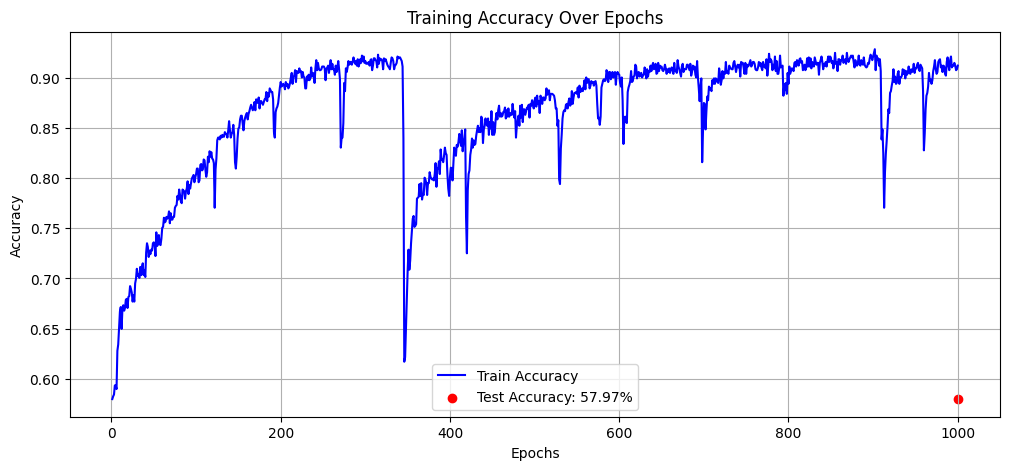

In [ ]:
input_size = len(seq_features)
static_size = len(static_features)
hidden_size = 32
num_layers = 2

model = NBAHybridModel(input_size, static_size, hidden_size, num_layers)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 1000
loss_history = []
train_acc_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for home_seq, away_seq, static_feats, labels in train_loader:
        home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(home_seq, away_seq, static_feats).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    loss_history.append(avg_loss)
    train_acc_history.append(train_accuracy)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.4f}")

# Evaluate test accuracy
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for home_seq, away_seq, static_feats, labels in test_loader:
        home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)
        outputs = model(home_seq, away_seq, static_feats).squeeze()
        predicted = (outputs > 0.5).float()
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test

# Plot training accuracy over epochs
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), train_acc_history, label="Train Accuracy", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Epochs")

plt.scatter([epochs], [test_accuracy], color='red', label=f"Test Accuracy: {test_accuracy:.2%}")

plt.legend()
plt.grid()
plt.show()

Notes

no exploration of hyperparameters (just wrote something basic that is not very good to try it)

tried a hybrid architecture because it seems popular online

What data do i need. What can i get rid of.

Need to get the most updated data and continue.

Deep learning should be considered. I need a large input

How do I format my input?

Idea
- Input is the roster with each player and their most recent 10 games stats
- Input also includes team stats

Why is training accuracy high but testing is low?
- What causes those huge jumps in the data

Can i convert it to a percentage change of a team winning?

70 percent accuracy in the real world would be incredible



# ADDITIONS ON PART 2 START HERE

First attempt to reduce overfitting we will use dropout, weight decay, and early stopping

In [ ]:
class NBA_Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        home_seq, away_seq, static_feats = self.data[idx]
        return home_seq, away_seq, static_feats, self.labels[idx]

batch_size = 32
train_dataset = NBA_Dataset(train_data, train_labels)
test_dataset = NBA_Dataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Modified Hybrid model with Dropout to reduce overfitting
class NBAHybridModel(nn.Module):
    def __init__(self, input_size, static_size, hidden_size, num_layers, dropout=0.3):
        super(NBAHybridModel, self).__init__()
        # Added dropout to LSTM layers
        self.lstm_home = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.lstm_away = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.fc_static = nn.Linear(static_size, hidden_size)
        self.fc_combined = nn.Linear(hidden_size * 3, 64)
        self.fc_output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)  # Added dropout

    def forward(self, home_seq, away_seq, static_feats):
        _, (home_hidden, _) = self.lstm_home(home_seq)
        _, (away_hidden, _) = self.lstm_away(away_seq)

        static_out = self.relu(self.fc_static(static_feats))
        static_out = self.dropout(static_out)  # Dropout after static features

        combined = torch.cat((home_hidden[-1], away_hidden[-1], static_out), dim=1)
        x = self.relu(self.fc_combined(combined))
        x = self.dropout(x)  # Dropout after combining
        x = self.fc_output(x)
        return self.sigmoid(x)

In [ ]:
input_size = len(seq_features)
static_size = len(static_features)
hidden_size = 32
num_layers = 2

model = NBAHybridModel(input_size, static_size, hidden_size, num_layers, dropout=0.3)
criterion = nn.BCELoss()
# Added weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early Stopping parameters
epochs = 1000
early_stop_patience = 50
best_loss = float('inf')
epochs_no_improve = 0

loss_history = []
train_acc_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for home_seq, away_seq, static_feats, labels in train_loader:
        home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(home_seq, away_seq, static_feats).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    loss_history.append(avg_loss)
    train_acc_history.append(train_accuracy)

    # Early stopping logic
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping after {epoch+1} epochs.")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.4f}")

Epoch 50/1000, Loss: 0.5779, Train Acc: 0.6978
Epoch 100/1000, Loss: 0.5229, Train Acc: 0.7486
Epoch 150/1000, Loss: 0.4576, Train Acc: 0.7904
Epoch 200/1000, Loss: 0.4072, Train Acc: 0.8103
Epoch 250/1000, Loss: 0.3551, Train Acc: 0.8339
Epoch 300/1000, Loss: 0.3292, Train Acc: 0.8430
Epoch 350/1000, Loss: 0.2883, Train Acc: 0.8621
Epoch 400/1000, Loss: 0.2532, Train Acc: 0.8866
Epoch 450/1000, Loss: 0.2332, Train Acc: 0.8929
Epoch 500/1000, Loss: 0.2336, Train Acc: 0.8920
Early stopping after 517 epochs.


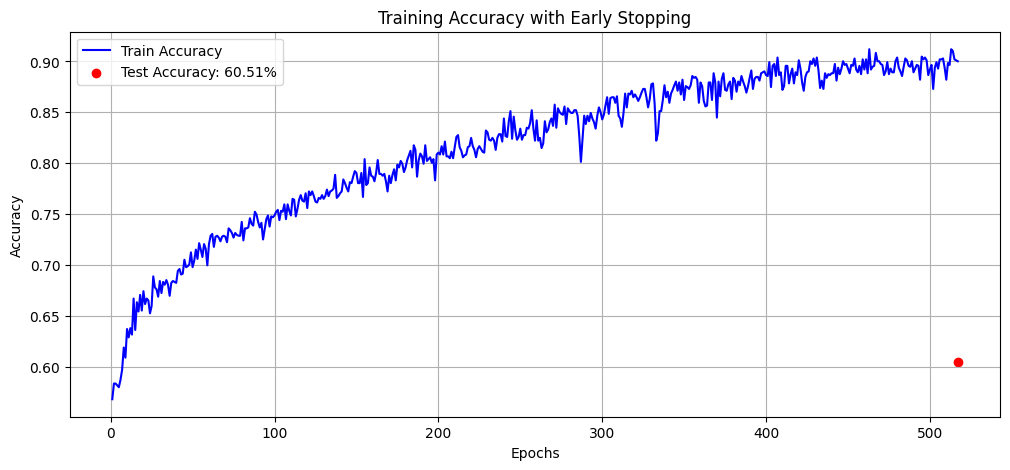

In [ ]:
# Evaluate test accuracy
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for home_seq, away_seq, static_feats, labels in test_loader:
        home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)
        outputs = model(home_seq, away_seq, static_feats).squeeze()
        predicted = (outputs > 0.5).float()
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test

# Plot training accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label="Train Accuracy", color='blue')
plt.scatter([len(train_acc_history)], [test_accuracy], color='red', label=f"Test Accuracy: {test_accuracy:.2%}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy with Early Stopping")
plt.legend()
plt.grid()
plt.show()

We are still struggling with overfitting here. We will usedropout and batch norm. We will also increase weight decay and use a learning rate scheduler to stop training earlier.

In [ ]:
class NBA_Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        home_seq, away_seq, static_feats = self.data[idx]
        return home_seq, away_seq, static_feats, self.labels[idx]

batch_size = 32
train_dataset = NBA_Dataset(train_data, train_labels)
test_dataset = NBA_Dataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Further simplified Hybrid model with stronger Dropout and BatchNorm
class NBAHybridModel(nn.Module):
    def __init__(self, input_size, static_size, hidden_size, num_layers, dropout=0.5):
        super(NBAHybridModel, self).__init__()
        self.lstm_home = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.lstm_away = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.fc_static = nn.Linear(static_size, hidden_size)
        self.fc_combined = nn.Linear(hidden_size * 3, 64)
        self.bn_combined = nn.BatchNorm1d(64)  # BatchNorm added
        self.fc_output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, home_seq, away_seq, static_feats):
        _, (home_hidden, _) = self.lstm_home(home_seq)
        _, (away_hidden, _) = self.lstm_away(away_seq)

        static_out = self.relu(self.fc_static(static_feats))
        static_out = self.dropout(static_out)

        combined = torch.cat((home_hidden[-1], away_hidden[-1], static_out), dim=1)
        x = self.fc_combined(combined)
        x = self.bn_combined(x)  # Batch normalization
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc_output(x)
        return self.sigmoid(x)

In [ ]:
input_size = len(seq_features)
static_size = len(static_features)
hidden_size = 16  # Reduced size
num_layers = 1    # Reduced complexity

dropout = 0.5
model = NBAHybridModel(input_size, static_size, hidden_size, num_layers, dropout=dropout)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)  # Increased weight decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 1000
early_stop_patience = 50
best_loss = float('inf')
epochs_no_improve = 0

loss_history = []
train_acc_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for home_seq, away_seq, static_feats, labels in train_loader:
        home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(home_seq, away_seq, static_feats).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    loss_history.append(avg_loss)
    train_acc_history.append(train_accuracy)

    scheduler.step(avg_loss)  # Learning rate scheduler step

    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping after {epoch+1} epochs.")
        break

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 50/1000, Loss: 0.5731, Train Acc: 0.7178
Epoch 100/1000, Loss: 0.5418, Train Acc: 0.7368
Epoch 150/1000, Loss: 0.5116, Train Acc: 0.7432
Epoch 200/1000, Loss: 0.4973, Train Acc: 0.7541
Epoch 250/1000, Loss: 0.5107, Train Acc: 0.7677
Epoch 300/1000, Loss: 0.5062, Train Acc: 0.7477
Early stopping after 314 epochs.


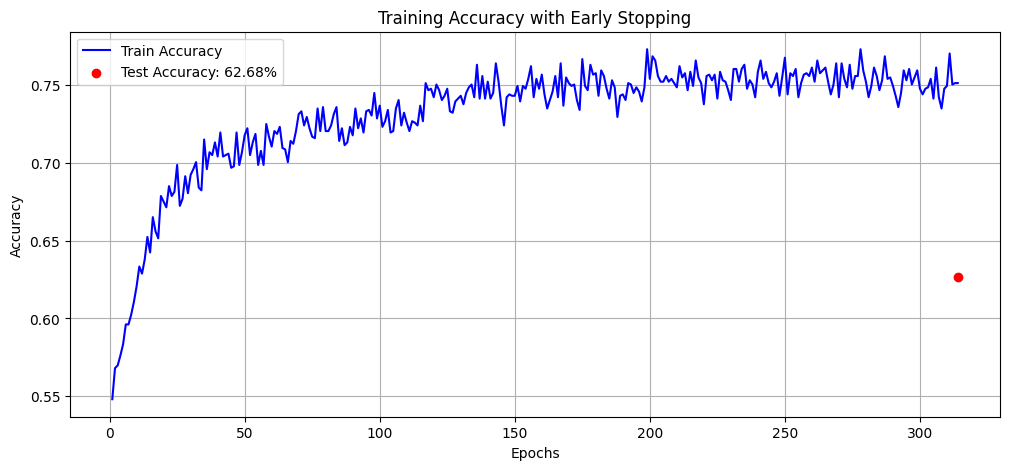

In [ ]:
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for home_seq, away_seq, static_feats, labels in test_loader:
        home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)
        outputs = model(home_seq, away_seq, static_feats).squeeze()
        predicted = (outputs > 0.5).float()
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test

plt.figure(figsize=(12, 5))
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label="Train Accuracy", color='blue')
plt.scatter([len(train_acc_history)], [test_accuracy], color='red', label=f"Test Accuracy: {test_accuracy:.2%}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy with Early Stopping")
plt.legend()
plt.grid()
plt.show()

We achieved 62% here which is higher than the ones previously but only marginally. I believe that using more data would help the model work better so we will try training with the additional data but the same model as above.

In [ ]:
# Load full dataset this time
games = pd.read_csv(path_to_games)
game_details = pd.read_csv(path_to_game_details)
ranking = pd.read_csv(path_to_ranking)

# Drop unnecessary columns
ranking = ranking.drop(columns=['LEAGUE_ID', 'SEASON_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'G', 'W', 'L', 'RETURNTOPLAY'], errors='ignore')
ranking = ranking.sort_values(by=['TEAM_ID'], ascending=True).drop_duplicates(subset=['TEAM_ID'], keep='last')
ranking_dict = ranking.set_index('TEAM_ID').to_dict(orient='index')

game_details = game_details[['GAME_ID', 'TEAM_ID', 'PTS', 'AST', 'REB', 'STL', 'BLK', 'TO', 'FG_PCT', 'FG3_PCT', 'FT_PCT']]

# Aggregate game details
game_details_agg = game_details.groupby(['GAME_ID', 'TEAM_ID']).agg({
    'PTS': 'sum', 'AST': 'sum', 'REB': 'sum', 'STL': 'sum',
    'BLK': 'sum', 'TO': 'sum', 'FG_PCT': 'mean', 'FG3_PCT': 'mean', 'FT_PCT': 'mean'
}).to_dict(orient='index')

# Prepare merged data
games = games.drop(columns=['GAME_STATUS_TEXT'], errors='ignore')
processed_data = []

for _, row in games.iterrows():
    game_id = row['GAME_ID']
    home_team = row['TEAM_ID_home']
    away_team = row['TEAM_ID_away']

    home_ranking = ranking_dict.get(home_team, {})
    away_ranking = ranking_dict.get(away_team, {})

    home_stats = game_details_agg.get((game_id, home_team), {})
    away_stats = game_details_agg.get((game_id, away_team), {})

    combined_row = {
        **row.to_dict(),
        **{f"{k}_home": v for k, v in home_ranking.items()},
        **{f"{k}_away": v for k, v in away_ranking.items()},
        **{f"{k}_home": v for k, v in home_stats.items()},
        **{f"{k}_away": v for k, v in away_stats.items()}
    }

    processed_data.append(combined_row)

games_final = pd.DataFrame(processed_data)

# Data normalization and pre-processing
N_GAMES = 10
stats_columns = ['PTS', 'AST', 'REB', 'STL', 'BLK', 'TO', 'FG_PCT', 'FG3_PCT', 'FT_PCT']
feature_rows = []

for _, game in games.iterrows():
    game_id = game['GAME_ID']
    home_team = game['TEAM_ID_home']
    away_team = game['TEAM_ID_away']

    home_games = [g for g in game_details[game_details['TEAM_ID'] == home_team].to_dict('records') if g['GAME_ID'] < game_id][-N_GAMES:]
    away_games = [g for g in game_details[game_details['TEAM_ID'] == away_team].to_dict('records') if g['GAME_ID'] < game_id][-N_GAMES:]

    def rolling_avg(games, stat):
        values = [g[stat] for g in games if not pd.isna(g[stat])]
        return np.mean(values) if values else 0

    home_features = {f"{stat}_home_avg": rolling_avg(home_games, stat) for stat in stats_columns}
    away_features = {f"{stat}_away_avg": rolling_avg(away_games, stat) for stat in stats_columns}

    home_win_pct = np.mean([1 if g['PTS'] > g['PTS'] else 0 for g in home_games]) if home_games else 0.5
    away_win_pct = np.mean([1 if g['PTS'] > g['PTS'] else 0 for g in away_games]) if away_games else 0.5

    row = {
        "GAME_ID": game_id,
        "HOME_TEAM_ID": home_team,
        "AWAY_TEAM_ID": away_team,
        "HOME_WIN": game["HOME_TEAM_WINS"],
        "HOME_WIN_PCT": home_win_pct,
        "AWAY_WIN_PCT": away_win_pct,
        **home_features,
        **away_features,
    }

    feature_rows.append(row)

features_df = pd.DataFrame(feature_rows)
features_df.fillna(0, inplace=True)

# Normalize static features
static_features = ['HOME_WIN_PCT', 'AWAY_WIN_PCT']
seq_features = stats_columns
scaler = StandardScaler()
features_df[static_features] = scaler.fit_transform(features_df[static_features])

# Prepare sequences
team_games = {}
sequences, targets = [], []

for _, row in features_df.iterrows():
    home_team, away_team = row['HOME_TEAM_ID'], row['AWAY_TEAM_ID']
    home_games = team_games.get(home_team, [])[-N_GAMES:]
    away_games = team_games.get(away_team, [])[-N_GAMES:]

    while len(home_games) < N_GAMES:
        home_games.insert(0, np.zeros(len(seq_features)))

    while len(away_games) < N_GAMES:
        away_games.insert(0, np.zeros(len(seq_features)))

    sequences.append((torch.tensor(home_games, dtype=torch.float32), torch.tensor(away_games, dtype=torch.float32), torch.tensor(row[static_features].values, dtype=torch.float32)))
    targets.append(row['HOME_WIN'])

    home_game_stats = row[[f"{stat}_home_avg" for stat in seq_features]].values
    away_game_stats = row[[f"{stat}_away_avg" for stat in seq_features]].values

    team_games.setdefault(home_team, []).append(home_game_stats)
    team_games.setdefault(away_team, []).append(away_game_stats)

sequences = [(torch.tensor(h, dtype=torch.float32), torch.tensor(a, dtype=torch.float32), torch.tensor(s, dtype=torch.float32)) for h, a, s in sequences]
targets = torch.tensor(targets, dtype=torch.float32)

train_data, test_data, train_labels, test_labels = train_test_split(sequences, targets, test_size=0.2, random_state=42)


<ipython-input-5-a6b96b1c0db2>:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  game_details = pd.read_csv(path_to_game_details)
<ipython-input-5-a6b96b1c0db2>:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  sequences.append((torch.tensor(home_games, dtype=torch.float32), torch.tensor(away_games, dtype=torch.float32), torch.tensor(row[static_features].values, dtype=torch.float32)))
<ipython-input-5-a6b96b1c0db2>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = [(torch.tensor(h, dtype=torch.float32), torch.tensor(a, dtype=torch.float32), torch.tensor

In [ ]:
# Saving the variables into a csv incase we need to use them again
import pickle
import os

# Paths for processed data
processed_features_path = '/content/drive/MyDrive/all_processed_features_df.csv'
sequences_path = '/content/drive/MyDrive/sequences.pkl'
targets_path = '/content/drive/MyDrive/targets.pkl'

# Save the files
features_df.to_csv(processed_features_path, index=False)

with open(sequences_path, 'wb') as f:
    pickle.dump(sequences, f)

with open(targets_path, 'wb') as f:
    pickle.dump(targets, f)

'''
# Paths for saving processed data
processed_features_path = 'all_processed_features_df.csv'
sequences_path = 'sequences.pkl'
targets_path = 'targets.pkl'

if os.path.exists(processed_features_path) and os.path.exists(sequences_path) and os.path.exists(targets_path):
    # Load previously processed data
    features_df = pd.read_csv(processed_features_path)
    with open(sequences_path, 'rb') as f:
        sequences = pickle.load(f)
    with open(targets_path, 'rb') as f:
        targets = pickle.load(f)
else:
    # If files don't exist, process the data and then save
    features_df.to_csv(processed_features_path, index=False)

    with open(sequences_path, 'wb') as f:
        pickle.dump(sequences, f)

    with open(targets_path, 'wb') as f:
        pickle.dump(targets, f)
'''


"\n# Paths for saving processed data\nprocessed_features_path = 'all_processed_features_df.csv'\nsequences_path = 'sequences.pkl'\ntargets_path = 'targets.pkl'\n\nif os.path.exists(processed_features_path) and os.path.exists(sequences_path) and os.path.exists(targets_path):\n    # Load previously processed data\n    features_df = pd.read_csv(processed_features_path)\n    with open(sequences_path, 'rb') as f:\n        sequences = pickle.load(f)\n    with open(targets_path, 'rb') as f:\n        targets = pickle.load(f)\nelse:\n    # If files don't exist, process the data and then save\n    features_df.to_csv(processed_features_path, index=False)\n\n    with open(sequences_path, 'wb') as f:\n        pickle.dump(sequences, f)\n\n    with open(targets_path, 'wb') as f:\n        pickle.dump(targets, f)\n"

Now with the updated dataset we can go ahead with training on the most recent model (This takes a long time (50 min) to run just a heads up if you plan to run it).

In [ ]:
class NBA_Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        home_seq, away_seq, static_feats = self.data[idx]
        return home_seq, away_seq, static_feats, self.labels[idx]

batch_size = 32
train_loader = DataLoader(NBA_Dataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(NBA_Dataset(test_data, test_labels), batch_size=batch_size, shuffle=False)

# Model definition
class NBAHybridModel(nn.Module):
    def __init__(self, input_size, static_size, hidden_size, num_layers, dropout=0.5):
        super(NBAHybridModel, self).__init__()
        self.lstm_home = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.lstm_away = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.fc_static = nn.Linear(static_size, hidden_size)
        self.fc_combined = nn.Linear(hidden_size * 3, 64)
        self.bn_combined = nn.BatchNorm1d(64)
        self.fc_output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def forward(self, home_seq, away_seq, static_feats):
        _, (home_hidden, _) = self.lstm_home(home_seq)
        _, (away_hidden, _) = self.lstm_away(away_seq)

        static_out = self.relu(self.fc_static(static_feats))
        static_out = self.dropout(static_out)

        combined = torch.cat((home_hidden[-1], away_hidden[-1], static_out), dim=1)
        x = self.fc_combined(combined)
        x = self.bn_combined(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc_output(x)
        return self.sigmoid(x)

NameError: name 'train_data' is not defined

In [ ]:
input_size = 9  # Number of sequential features
static_size = 2  # Number of static features
hidden_size = 16
num_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NBAHybridModel(input_size, static_size, hidden_size, num_layers).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# Training loop with Early Stopping
epochs = 1000
early_stop_patience = 50
best_loss = float('inf')
epochs_no_improve = 0
loss_history, train_acc_history = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct_train, total_train = 0, 0, 0

    for home_seq, away_seq, static_feats, labels in train_loader:
        home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(home_seq, away_seq, static_feats).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    loss_history.append(avg_loss)
    train_acc_history.append(train_accuracy)

    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping after {epoch+1} epochs.")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 10/1000, Loss: 0.6723, Train Acc: 0.5911
Epoch 20/1000, Loss: 0.6711, Train Acc: 0.5919


KeyboardInterrupt: 

In [ ]:
model.eval()
correct_test, total_test = 0, 0

with torch.no_grad():
    for home_seq, away_seq, static_feats, labels in test_loader:
        home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)
        outputs = model(home_seq, away_seq, static_feats).squeeze()
        predicted = (outputs > 0.5).float()
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test

# Plot training accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label="Train Accuracy", color='blue')
plt.scatter([len(train_acc_history)], [test_accuracy], color='red', label=f"Test Accuracy: {test_accuracy:.2%}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy with Early Stopping")
plt.legend()
plt.grid()
plt.show()

I was hoping that after this the accuracy would magically go up but this did not happen. It seems that the training accuracy and the testing accuracy both went down but the spread is closer.

Now i have the data saved in drive and I will use it to explore some hyper paramaters in hopes of moving accuracy towards 70%. Based on resources I have seen online, >65% accuracy would mean that I am capturing insights that the betting markets are not fully understanding. If I can achieve this I would be very happy. With an accuracy between 60% and 65% would be very good but would be similar to expert picks. This would be very good and would be a "money maker".

In [ ]:
# Paths where your pickled files are stored
import pickle
import os

sequences_path = '/content/drive/MyDrive/sequences.pkl'
targets_path = '/content/drive/MyDrive/targets.pkl'

# Load sequences
with open(sequences_path, 'rb') as file:
    sequences = pickle.load(file)

# Load targets
with open(targets_path, 'rb') as file:
    targets = pickle.load(file)


In [ ]:
import itertools

hidden_sizes = [16, 32, 64]
dropout_rates = [0.3, 0.5, 0.7]
weight_decays = [1e-4, 5e-4, 1e-3]

best_accuracy = 0
best_params = {}
results = []

# Loop over hyperparameter combinations
for hidden_size, dropout, weight_decay in itertools.product(hidden_sizes, dropout_rates, weight_decays):
    print(f"Training with hidden_size={hidden_size}, dropout={dropout}, weight_decay={weight_decay}")

    # Model definition
    model = NBAHybridModel(input_size, static_size, hidden_size, num_layers, dropout).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

    epochs = 100
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for home_seq, away_seq, static_feats, labels in train_loader:
            home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(home_seq, away_seq, static_feats).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    # Evaluate on test data
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for home_seq, away_seq, static_feats, labels in test_loader:
            home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)
            outputs = model(home_seq, away_seq, static_feats).squeeze()
            predicted = (outputs > 0.5).float()
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    accuracy = correct_test / total_test
    results.append((hidden_size, dropout, weight_decay, accuracy))
    print(f"Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'hidden_size': hidden_size, 'dropout': dropout, 'weight_decay': weight_decay}

# Display results
results_df = pd.DataFrame(results, columns=['hidden_size', 'dropout', 'weight_decay', 'accuracy'])
print("\nBest Hyperparameters:", best_params)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
for key, grp in results_df.groupby(['hidden_size']):
    ax = grp.plot(ax=ax, kind='line', x='dropout', y='accuracy', label=f"Hidden Size {key}", marker='o')

plt.title("Hyperparameter Exploration Results")
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()


Training with hidden_size=16, dropout=0.3, weight_decay=0.0001


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Accuracy: 0.5884
Training with hidden_size=16, dropout=0.3, weight_decay=0.0005
Accuracy: 0.5909
Training with hidden_size=16, dropout=0.3, weight_decay=0.001
Accuracy: 0.5873
Training with hidden_size=16, dropout=0.5, weight_decay=0.0001


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Accuracy: 0.5841
Training with hidden_size=16, dropout=0.5, weight_decay=0.0005
Accuracy: 0.5826
Training with hidden_size=16, dropout=0.5, weight_decay=0.001
Accuracy: 0.5894
Training with hidden_size=16, dropout=0.7, weight_decay=0.0001


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn(


Accuracy: 0.5873
Training with hidden_size=16, dropout=0.7, weight_decay=0.0005
Accuracy: 0.5903
Training with hidden_size=16, dropout=0.7, weight_decay=0.001
Accuracy: 0.5871
Training with hidden_size=32, dropout=0.3, weight_decay=0.0001
Accuracy: 0.5802
Training with hidden_size=32, dropout=0.3, weight_decay=0.0005
Accuracy: 0.5839
Training with hidden_size=32, dropout=0.3, weight_decay=0.001
Accuracy: 0.5877
Training with hidden_size=32, dropout=0.5, weight_decay=0.0001
Accuracy: 0.5877
Training with hidden_size=32, dropout=0.5, weight_decay=0.0005
Accuracy: 0.5864
Training with hidden_size=32, dropout=0.5, weight_decay=0.001


In [ ]:
import itertools

hidden_sizes = [64]
dropout_rates = [0.3, 0.5, 0.7]
weight_decays = [1e-4, 5e-4, 1e-3]

best_accuracy = 0
best_params = {}
results = []

# Loop over hyperparameter combinations
for hidden_size, dropout, weight_decay in itertools.product(hidden_sizes, dropout_rates, weight_decays):
    print(f"Training with hidden_size={hidden_size}, dropout={dropout}, weight_decay={weight_decay}")

    # Model definition
    model = NBAHybridModel(input_size, static_size, hidden_size, num_layers, dropout).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

    epochs = 100
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for home_seq, away_seq, static_feats, labels in train_loader:
            home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(home_seq, away_seq, static_feats).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    # Evaluate on test data
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for home_seq, away_seq, static_feats, labels in test_loader:
            home_seq, away_seq, static_feats, labels = home_seq.to(device), away_seq.to(device), static_feats.to(device), labels.to(device)
            outputs = model(home_seq, away_seq, static_feats).squeeze()
            predicted = (outputs > 0.5).float()
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    accuracy = correct_test / total_test
    results.append((hidden_size, dropout, weight_decay, accuracy))
    print(f"Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'hidden_size': hidden_size, 'dropout': dropout, 'weight_decay': weight_decay}

# Display results
results_df = pd.DataFrame(results, columns=['hidden_size', 'dropout', 'weight_decay', 'accuracy'])
print("\nBest Hyperparameters:", best_params)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
for key, grp in results_df.groupby(['hidden_size']):
    ax = grp.plot(ax=ax, kind='line', x='dropout', y='accuracy', label=f"Hidden Size {key}", marker='o')

plt.title("Hyperparameter Exploration Results")
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()


Training with hidden_size=64, dropout=0.3, weight_decay=0.0001


NameError: name 'NBAHybridModel' is not defined